In [1]:
import os
import tensorflow as tf
print(tf.__version__)


2.10.1


In [2]:
import tensorflow as tf
import GPUtil

# I am checking the TensorFlow with GPU information, since I am using two differente conda evn to run 2 tasks
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print(f"Number of GPUs Available: {len(gpus)}")

if gpus:
    print("\nGPU Details (from TensorFlow):")
    for i, gpu in enumerate(gpus):
        print(f" [{i}] Name: {gpu.name} | Type: {gpu.device_type}")

    print("\nGPU Details (from GPUtil):")
    for i, gpu in enumerate(GPUtil.getGPUs()):
        print(f" [{i}] ID: {gpu.id} | Name: {gpu.name} | Load: {gpu.load*100:.1f}% | Memory Free: {gpu.memoryFree} MB")
else:
    print("No GPU detected. Running on CPU.")

TensorFlow version: 2.10.1
Number of GPUs Available: 1

GPU Details (from TensorFlow):
 [0] Name: /physical_device:GPU:0 | Type: GPU

GPU Details (from GPUtil):
 [0] ID: 0 | Name: NVIDIA GeForce RTX 4070 SUPER | Load: 35.0% | Memory Free: 283.0 MB


In [3]:
import os
import cv2
import math
import shutil
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models, applications, preprocessing, optimizers, callbacks, regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.initializers import glorot_uniform, he_normal
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Input, Dense, Lambda, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, Add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

import zipfile
from zipfile import ZipFile
from IPython import display
from IPython.display import HTML, display, clear_output, SVG, set_matplotlib_formats, Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings("ignore")

In [4]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
SPLIT_DATA = "C:/Users/tonyh_yxuq8za/Desktop/TONY_AI/Tail_Light_Detection/Data_Brake_Split"

In [5]:
train_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    os.path.join(SPLIT_DATA, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    os.path.join(SPLIT_DATA, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    os.path.join(SPLIT_DATA, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 125656 images belonging to 2 classes.
Found 26926 images belonging to 2 classes.
Found 26928 images belonging to 2 classes.


In [6]:
NUM_CLASSES = len(train_gen.class_indices)
print("Class indices:", train_gen.class_indices)
print("Number of classes:", NUM_CLASSES)
print("Number of training samples:", train_gen.samples)
print("Number of validation samples:", val_gen.samples)
print("Number of test samples:", test_gen.samples)

Class indices: {'brake_brakeoff': 0, 'brake_brakeon': 1}
Number of classes: 2
Number of training samples: 125656
Number of validation samples: 26926
Number of test samples: 26928


In [7]:
y_train = train_gen.classes
cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(cw))
print("Class weights:", class_weight)

Class weights: {0: 0.9287213599408721, 1: 1.083129331448471}


In [8]:
CHECKPOINTING_DIR = "C:/Users/tonyh_yxuq8za/Desktop/TONY_AI/BRAKE_CHECK_MAIN_5"
os.makedirs(CHECKPOINTING_DIR, exist_ok = True)

In [9]:
CHECKPOINTING_PATH = os.path.join(
    CHECKPOINTING_DIR,
    "best_model_brake_main_5.keras"
)

In [10]:
checkpointing_cb = ModelCheckpoint(
    filepath = CHECKPOINTING_PATH,
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = "min",
    save_freq = "epoch"
)

In [11]:
model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       256       
 hNormalization)                                                 
                                                        

In [13]:
reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1,
    mode = 'min'
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience= 10,
    restore_best_weights=True,
    verbose=1,
    mode = 'min'
)

In [14]:
history = model.fit(
    train_gen,
    epochs=100, 
    validation_data=val_gen,
    class_weight=class_weight,
    callbacks=[checkpointing_cb, reduce_lr_cb, earlystop_cb],
    verbose=1
)

Epoch 1/100
3925/3927 [============================>.] - ETA: 0s - loss: 0.2819 - accuracy: 0.8859
Epoch 1: val_loss improved from inf to 0.37231, saving model to C:/Users/tonyh_yxuq8za/Desktop/TONY_AI/BRAKE_CHECK_MAIN_5\best_model_brake_main_5.keras
3927/3927 [==============================] - 106s 26ms/step - loss: 0.2819 - accuracy: 0.8859 - val_loss: 0.3723 - val_accuracy: 0.8474 - lr: 0.0010
Epoch 2/100
3924/3927 [============================>.] - ETA: 0s - loss: 0.1951 - accuracy: 0.9268
Epoch 2: val_loss improved from 0.37231 to 0.20665, saving model to C:/Users/tonyh_yxuq8za/Desktop/TONY_AI/BRAKE_CHECK_MAIN_5\best_model_brake_main_5.keras
3927/3927 [==============================] - 46s 12ms/step - loss: 0.1951 - accuracy: 0.9268 - val_loss: 0.2066 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 3/100
3927/3927 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9367
Epoch 3: val_loss improved from 0.20665 to 0.16412, saving model to C:/Users/tonyh_yxuq8za/Desktop

In [15]:
test_loss, test_accuracy = model.evaluate(test_gen, steps = len(test_gen), verbose = 1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

train_loss, train_accuracy = model.evaluate(train_gen, steps = len(train_gen), verbose = 1)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

842/842 [==============================] - 17s 20ms/step - loss: 0.1116 - accuracy: 0.9619
Test Loss: 0.11157802492380142
Test Accuracy: 0.9619355201721191
3927/3927 [==============================] - 39s 10ms/step - loss: 0.0434 - accuracy: 0.9830
Train Loss: 0.04342721030116081
Train Accuracy: 0.9829614162445068


In [16]:
val_loss, val_accuracy = model.evaluate(val_gen, steps = len(val_gen), verbose = 1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

842/842 [==============================] - 8s 10ms/step - loss: 0.1092 - accuracy: 0.9630
Validation Loss: 0.10915350168943405
Validation Accuracy: 0.9629725813865662


In [22]:
y_test = test_gen.classes

In [23]:
y_preds =  model.predict(test_gen, steps = len(test_gen))
y_preds_model = np.argmax(y_preds, axis = 1)

842/842 [==============================] - 19s 23ms/step


In [24]:
accuracy_score_baseline_model = accuracy_score(y_test, y_preds_model)
print(f"Accuracy Score: {accuracy_score_baseline_model}")
precision_score_baseline_model = precision_score(y_test, y_preds_model, average = "macro")
print(f"Precision Score: {precision_score_baseline_model}")
recall_score_baseline_model = recall_score(y_test, y_preds_model, average = "macro")
print(f"Recall Score: {recall_score_baseline_model}")
f1_score_baseline_model = f1_score(y_test, y_preds_model, average = "macro")
print(f"F1 Score: {f1_score_baseline_model}")

Accuracy Score: 0.961935531788473
Precision Score: 0.9627169017550052
Recall Score: 0.9608187945892034
F1 Score: 0.961636603360525


842/842 [==============================] - 8s 10ms/step
Classification Report:
                precision    recall  f1-score   support

brake_brakeoff       0.95      0.98      0.97     14497
 brake_brakeon       0.97      0.95      0.96     12431

      accuracy                           0.96     26928
     macro avg       0.96      0.96      0.96     26928
  weighted avg       0.96      0.96      0.96     26928



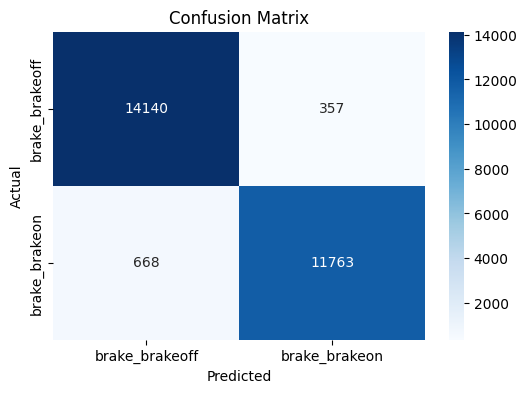

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(train_gen.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

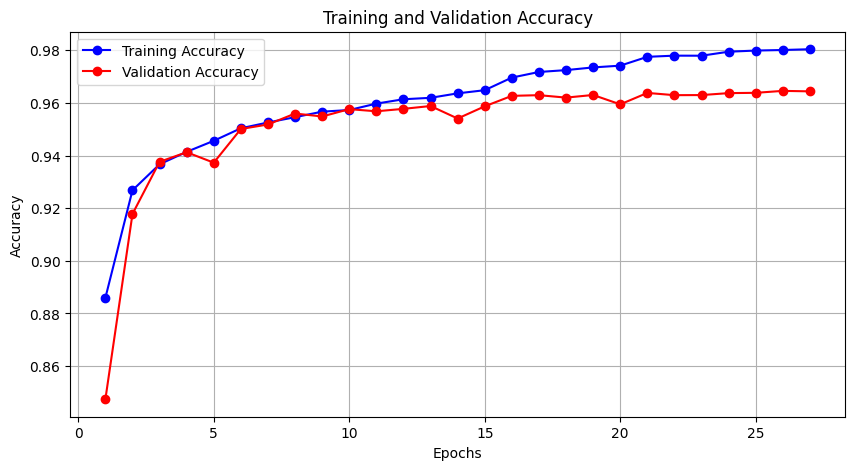

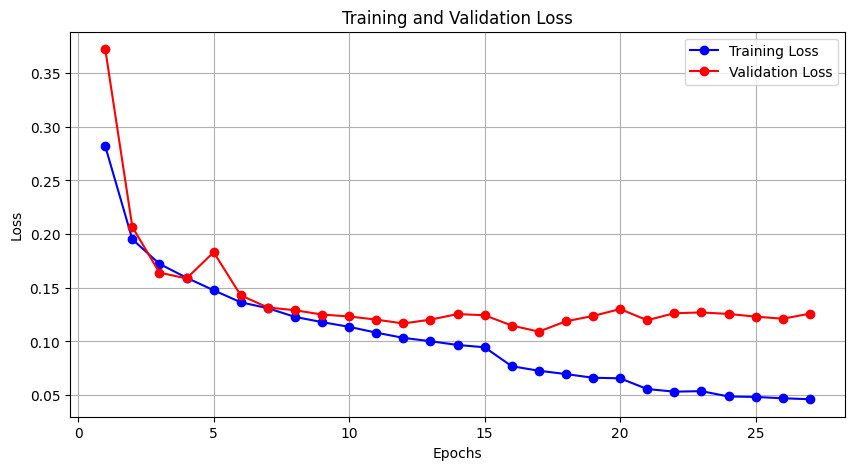

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:

# keras_model_path = "C:/Users/tonyh_yxuq8za/Desktop/TONY_AI/BRAKE_CHECK_MAIN_2/best_model_brake_main_2.keras"

# # Load model
# model = tf.keras.models.load_model(keras_model_path)

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# tflite_model_path = keras_model_path.replace(".keras", ".tflite")
# with open(tflite_model_path, "wb") as f:
#     f.write(tflite_model)

# print(f"TFLite model saved at:\n{tflite_model_path}")
